# STA 141B: Homework 6
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name:Hemiao

Last Name: Cui

Student ID: 999470055

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Web scraping the Aggie

In this assignment, you'll scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Aggie for analysis in exercise 1.4.

__Exercise 1.1.__ Write a function that extracts all of the links to articles in an Aggie article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Have a parameter `page` for the number of pages to fetch links from. The default should be `1`.

* Return a list of aricle URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite to The Aggie and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* Start by getting your function to work for just 1 page. Once that works, have your function call itself to get additional pages.

* You can use [lxml.html](http://lxml.de/lxmlhtml.html) or [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape HTML. Choose one and use it throughout the entire assignment.

In [1]:
import requests
import requests_cache
requests_cache.install_cache("my_hw6_cache") 
from bs4 import BeautifulSoup
import lxml.html as lx
import numpy as np
import pandas as pd
import wordcloud
from matplotlib import pyplot as plt
%matplotlib inline
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import re

In [2]:
def get_links(url,pages=1):
    response=requests.get(url)
    doc=response.text
    html=lx.fromstring(doc)
    linksource=html.xpath("/html/body//h2//a")
    linklist=[item.attrib['href']for item in linksource]
    nextpage=html.xpath("/html/body//a[@class='next page-numbers']")[0].attrib['href']
    linklist_next=[]
    if pages!=1:
        linklist_next=get_links(nextpage,pages-1)
    return linklist+linklist_next

In [3]:
get_links("https://theaggie.org/city/",5)

['https://theaggie.org/2018/03/13/police-logs-44/',
 'https://theaggie.org/2018/03/13/davis-students-pedal-for-polar-bears/',
 'https://theaggie.org/2018/03/12/sixth-annual-climate-conference-growing-resilient-forests/',
 'https://theaggie.org/2018/03/11/new-committee-members-to-join-yolo-county/',
 'https://theaggie.org/2018/03/11/yolo-rainbow-families-hosts-workshops-about-gender-diverse-children/',
 'https://theaggie.org/2018/03/08/uc-davis-student-fighting-for-new-city-flag/',
 'https://theaggie.org/2018/03/06/soroptimist-international-greater-davis-presents-college-scholarships-women/',
 'https://theaggie.org/2018/03/06/police-logs-43/',
 'https://theaggie.org/2018/03/06/grant-awarded-yolo-hospice/',
 'https://theaggie.org/2018/03/05/davis-enterprise-welcomes-new-editor/',
 'https://theaggie.org/2018/03/05/davis-city-council-candidate-exits-election-race/',
 'https://theaggie.org/2018/03/04/electric-buses-coming-sacramento/',
 'https://theaggie.org/2018/03/01/sacramento-makes-traf

In [4]:
get_links("https://theaggie.org/opinion/",2)

['https://theaggie.org/2018/03/13/the-glorification-of-narco-culture/',
 'https://theaggie.org/2018/03/13/humor-sacrificing-virgins-leads-to-low-number-of-students-in-computer-science/',
 'https://theaggie.org/2018/03/12/is-environmentalism-for-everyone/',
 'https://theaggie.org/2018/03/12/humor-budget-cuts-select-faculty-to-be-sacrificed-to-gunrock-effigy/',
 'https://theaggie.org/2018/03/12/humor-i-lived-it-i-survived-being-mansplained-to/',
 'https://theaggie.org/2018/03/12/the-blood-price-of-american-news/',
 'https://theaggie.org/2018/03/12/realizing-my-privilege-in-education/',
 'https://theaggie.org/2018/03/12/humor-coho-hacks-annual-hackathon-to-be-held-while-coders-wait-in-line-for-their-food/',
 'https://theaggie.org/2018/03/09/letter-to-the-editor-20/',
 'https://theaggie.org/2018/03/09/aggie-basketball-dominates-big-west/',
 'https://theaggie.org/2018/03/08/humor-the-most-davis-ways-to-tell-your-girlfriend-you-have-a-second-family/',
 'https://theaggie.org/2018/03/08/black-

__Exercise 1.2.__ Write a function that extracts the title, text, and author of an Aggie article. The function should:

* Have a parameter `url` for the URL of the article.

* For the author, extract the "Written By" line that appears at the end of most articles. You don't have to extract the author's name from this line.

* Return a dictionary with keys "url", "title", "text", and "author". The values for these should be the article url, title, text, and author, respectively.

For example, for [this article](https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/) your function should return something similar to this:
```
{
    'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
    'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effort will mesh well with our other efforts as we build the budget for the next fiscal year and beyond." Project Toto complements the city\'s effort to amplify the transparency of city decisions to community members. The aim is to increase the understanding about the city\'s financial situation and make the information more accessible and easier to understand. The project is mostly a tool for public education, but can also make predictions about potential decisions regarding the city\'s financial future. Once completed, the program will allow residents to manipulate variables to see their eventual consequences, such as tax increases or extensions and proposed developments "This really isn\'t a budget, it is a forecast to see the intervention of these decisions," Williams said in an interview with The Davis Enterprise. "What happens if we extend the sales tax? What does it do given the other numbers that are in?" Project Toto enables users, whether it be a curious Davis resident, a concerned community member or a city leader, with the ability to project city finances with differing variables. The online program consists of the 400-page city budget for the 2016-2017 fiscal year, the previous budget, staff reports and consultant analyses. All of the documents are cited and accessible to the public within Project Toto. "It\'s a model that very easily lends itself to visual representation," Mayor Robb Davis said. "You can see the impacts of decisions the council makes on the fiscal health of the city." Complementary to this program, there is also a more advanced version of the model with more in-depth analyses of the city\'s finances. However, for an easy-to-understand, simplistic overview, Project Toto should be enough to help residents comprehend Davis finances. There is still more to do on the project, but its creators are hard at work trying to finalize it before the 2017-2018 fiscal year budget. "It\'s something I have been very much supportive of," Davis said. "Transparency is not just something that I have been supportive of but something we have stated as a city council objective [ ] this fits very well with our attempt to inform the public of our challenges with our fiscal situation." ',
    'title': 'Project Toto aims to address questions regarding city finances',
    'url': 'https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/'
}
```

Hints:

* The author line is always the last line of the last paragraph.

* If you are having trouble working with unicode characters see [the python 3 documentation](https://docs.python.org/3/howto/unicode.html).

In [5]:
def get_text(url):
    response=requests.get(url)
    doc=response.text
    html=lx.fromstring(doc)
    author=html.xpath("/html//article//header//a")[0].text.encode('ascii', 'ignore')
    temp=html.xpath("/html/body//article//p")
    temp1=[item.text_content() for item in temp]
    removed_none=[item for item in temp1 if item is not None]
    text=",".join(removed_none).encode('ascii', 'ignore')
    title=(html.xpath("/html/body//article//header/h1")[0].text).encode('ascii', 'ignore')
    url=(html.xpath("/html/head//link")[0].attrib['href']).encode('ascii', 'ignore')
    return {'author':author,'text':text,'title':title,'url':url}

In [6]:
get_text("https://theaggie.org/2018/02/12/senator-term-review-michael-gofman/")

{'author': ' Elizabeth Mercado  campus@theaggie.org',
 'text': 'A year of accomplishments, controversy, pursuits for the executive office,Michael Gofman, a second-year economics and political science double major, has been serving his term as an ASUCD senator since he was elected in Winter Elections of 2017. Gofman ran on the platforms of environmental sustainability, affordability for low-income students and student-teacher relations.,ASUCD President Josh Dalavai and Vice President Adilla Jamaludin described Gofman as composed, organized and proactive during his campaign for Senate.,I wanted to get more involved in our student government, Gofman said. I figured joining the ASUCD Senate would be the best way in order to create some of the changes that I wanted to see on campus and tackle some of the problems that I had heard from other students going on with campus.,In office, Gofman has served as the adopted senator for the Campus Center for Environment, the Bike Barn, the CoHo, Enter

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get a data frame of 60 [Campus News](https://theaggie.org/campus/) articles and a data frame of 60 [City News](https://theaggie.org/city/) articles. Add a column to each that indicates the category, then combine them into one big data frame.

The "text" column of this data frame will be your corpus for natural language processing in exercise 1.4.

In [7]:
links_campus=get_links("https://theaggie.org/campus/",pages=4)
df_campus=pd.DataFrame([get_text(item) for item in links_campus])
df_campus['author']=np.array([item.replace("campus@theaggie.org","") for item in df_campus['author']])
df_campus

,author,text,title,url
0,Jacqueline Moore,"Guy-Uriel Charles speaks at King Hall,Duke Uni...",Duke law professor presents lecture on voting ...,https://theaggie.org/2018/03/06/duke-law-profe...
1,Priyanka Shreedar,Controversial prosecution of UC Davis student ...,Last Week in Senate,https://theaggie.org/2018/03/05/last-week-sena...
2,Clara Zhao,Scammers contact students posing as potential ...,ICC warns students to be wary of suspicious jo...,https://theaggie.org/2018/03/05/icc-warns-stud...
3,Aaron Liss,"Noah Benham faces four charges,On the night of...",UC Davis student protester arrested at Yiannop...,https://theaggie.org/2018/03/04/uc-davis-stude...
4,Elizabeth Mercado,"ACT slate candidates, disqualified Golden Slat...",Executive ticket candidates claim biases again...,https://theaggie.org/2018/03/01/executive-tick...
5,George Liao,The Happiness Campaign seeks to reduce anxiety...,"Happiness Campaign strives for less stress, mo...",https://theaggie.org/2018/03/01/happiness-camp...
6,Sabrina Habchi,"Ramirez Sigalas performance as ASUCD senator,A...",Senator Term Review: Yajaira Ramirez Sigala,https://theaggie.org/2018/02/27/senator-term-r...
7,Clara Zhao,"History behind CALPIRG,Who are the people with...",CALPIRGs Winter Quarter pledge drives,https://theaggie.org/2018/02/27/calpirgs-winte...
8,Clara Zhao,"President Michael Gofman, Vice President Shani...",ASUCD election results announced,https://theaggie.org/2018/02/26/asucd-election...
9,George Liao,Systemwide student advisory board formed to in...,Sexual Violence Prevention and Response Board ...,https://theaggie.org/2018/02/26/sexual-violenc...


In [8]:
links_city=get_links("https://theaggie.org/city/",pages=4)
df_city=pd.DataFrame([get_text(item) for item in links_city])
df_city['author']=np.array([item.replace("city@theaggie.org","") for item in df_city['author']])
df_city

,author,text,title,url
0,theaggie,"Who is Monica?,Feb. 19,Heard only for last 10 ...",Police Logs,https://theaggie.org/2018/03/13/police-logs-44/
1,Genevieve Murphy-Skilling,Students bike in freezing conditions to help p...,Davis students pedal for polar bears,https://theaggie.org/2018/03/13/davis-students...
2,Rabiya Oberoi,Yolo Interfaith Alliance for Climate Justice h...,Sixth annual climate conference: growing resil...,https://theaggie.org/2018/03/12/sixth-annual-c...
3,Stella Tran,Financial Oversight Committee has open seats t...,New committee members to join Yolo County,https://theaggie.org/2018/03/11/new-committee-...
4,Hannan Waliullah,Workshop aimed to help parents understand chil...,Yolo Rainbow Families hosts workshops about ge...,https://theaggie.org/2018/03/11/yolo-rainbow-f...
5,Dylan Svoboda,City Councilmembers reluctant to recognize new...,UC Davis student fighting for new city flag,https://theaggie.org/2018/03/08/uc-davis-stude...
6,Hannan Waliullah,Organizations annual Live Your Dream Awards pr...,Soroptimist International of Greater Davis pre...,https://theaggie.org/2018/03/06/soroptimist-in...
7,theaggie,"Keep your own trash,Feb. 13,Reporting party be...",Police Logs,https://theaggie.org/2018/03/06/police-logs-43/
8,Rabiya Oberoi,"Yolo Hospice receives $60,000 grant for advanc...",Grant awarded to Yolo Hospice,https://theaggie.org/2018/03/06/grant-awarded-...
9,Ahash Francis,Sebastian Oate to replace Debbie Davis as edit...,Davis Enterprise welcomes new editor,https://theaggie.org/2018/03/05/davis-enterpri...


In [9]:
df_joined=pd.concat([df_campus,df_city])
df_joined.head()

,author,text,title,url
0,Jacqueline Moore,"Guy-Uriel Charles speaks at King Hall,Duke Uni...",Duke law professor presents lecture on voting ...,https://theaggie.org/2018/03/06/duke-law-profe...
1,Priyanka Shreedar,Controversial prosecution of UC Davis student ...,Last Week in Senate,https://theaggie.org/2018/03/05/last-week-sena...
2,Clara Zhao,Scammers contact students posing as potential ...,ICC warns students to be wary of suspicious jo...,https://theaggie.org/2018/03/05/icc-warns-stud...
3,Aaron Liss,"Noah Benham faces four charges,On the night of...",UC Davis student protester arrested at Yiannop...,https://theaggie.org/2018/03/04/uc-davis-stude...
4,Elizabeth Mercado,"ACT slate candidates, disqualified Golden Slat...",Executive ticket candidates claim biases again...,https://theaggie.org/2018/03/01/executive-tick...


__Exercise 1.4.__ Use the Aggie corpus to answer the following questions. Use plots to support your analysis.

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

* Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

Hints:

*   The [nltk book](http://www.nltk.org/book/) and [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) may be helpful here.

*   You can determine whether city articles are "near" campus articles from the similarity matrix or with k-nearest neighbors.

*   If you want, you can use the [wordcloud](http://amueller.github.io/word_cloud/) package to plot a word cloud. To install the package, run
    ```
    conda install -c https://conda.anaconda.org/amueller wordcloud
    ```
    in a terminal. Word clouds look nice and are easy to read, but are less precise than bar plots.

In [10]:
#1.4.1 What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?
the_stopwords = set(["university", "uc", "davis", "yolo", "city", "campus", "said", "year", "student", "students","new", "people", "sacramento" ])
swords = set(stopwords.words()).union(the_stopwords)
def stop_word_removed(text):
    """this function removes stopwords"""
    temp= TextBlob(text)
    new_text = " ".join(w for w in temp.words if w.lower() not in swords)
    blob = TextBlob(new_text)
    return blob
def wordnet_pos(tag): 
    """Map a Brown POS tag to a WordNet POS tag."""
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ} 
    return table.get(tag[0], wordnet.NOUN)
def blob_txt(text):
    """this functon tokenize and stemmatize the text"""
    blob=stop_word_removed(text)
    tags = [wordnet_pos(x[1]) for x in blob.pos_tags] 
    new_text = " ".join(x.lemmatize(t) for x, t in zip(blob.words, tags))
    return TextBlob(new_text)
def get_word_cloud(text):
    image=wordcloud.WordCloud(background_color = "white",max_words=800,width=800, height=400)
    image.generate(text)
    return image

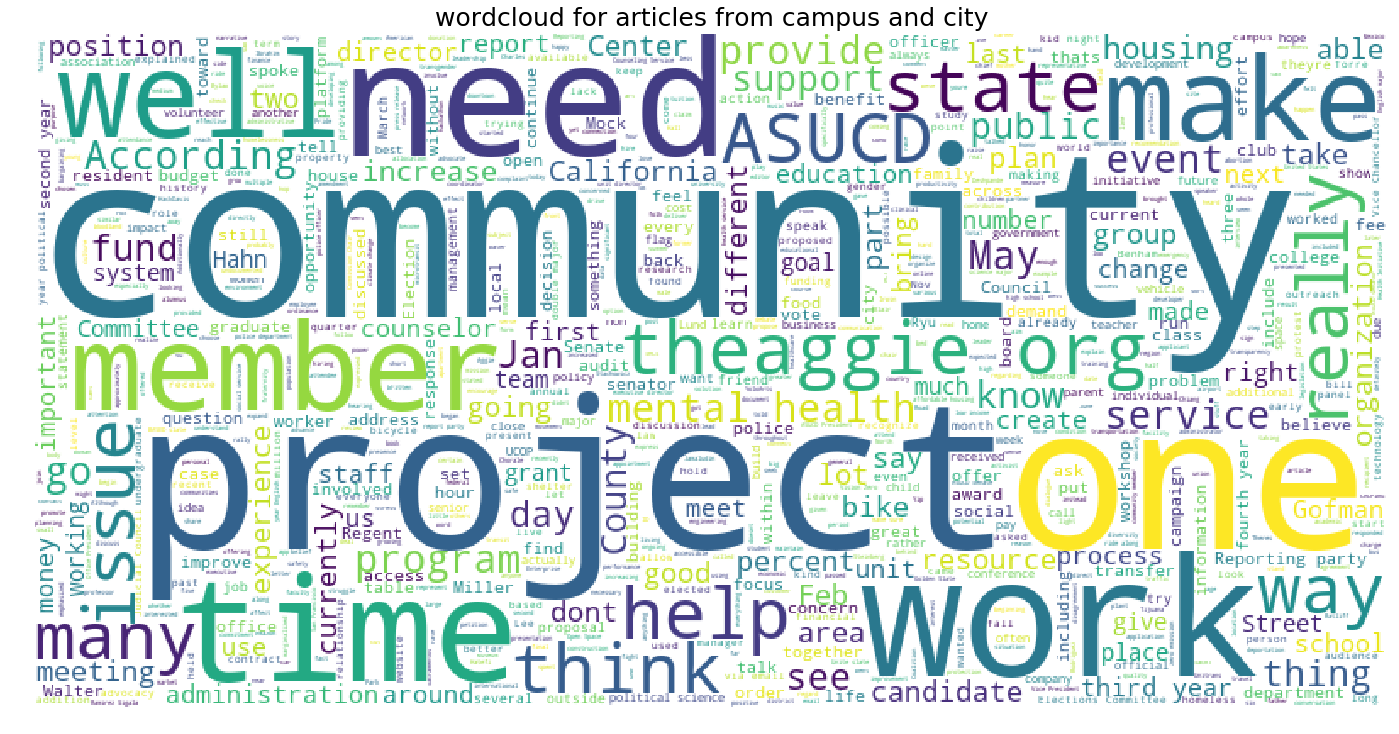

In [12]:
#wordcloud for joined dataframe
text=",".join(df_joined.text)
joined_text=blob_txt(text)
image=get_word_cloud("".join(joined_text))
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.axis("off")
plt.title("wordcloud for articles from campus and city",fontsize=25)
plt.tight_layout(pad=0)
plt.show()

From above wordcloud, we can see project and comunity, time, member are the top topic of a aggie article. 

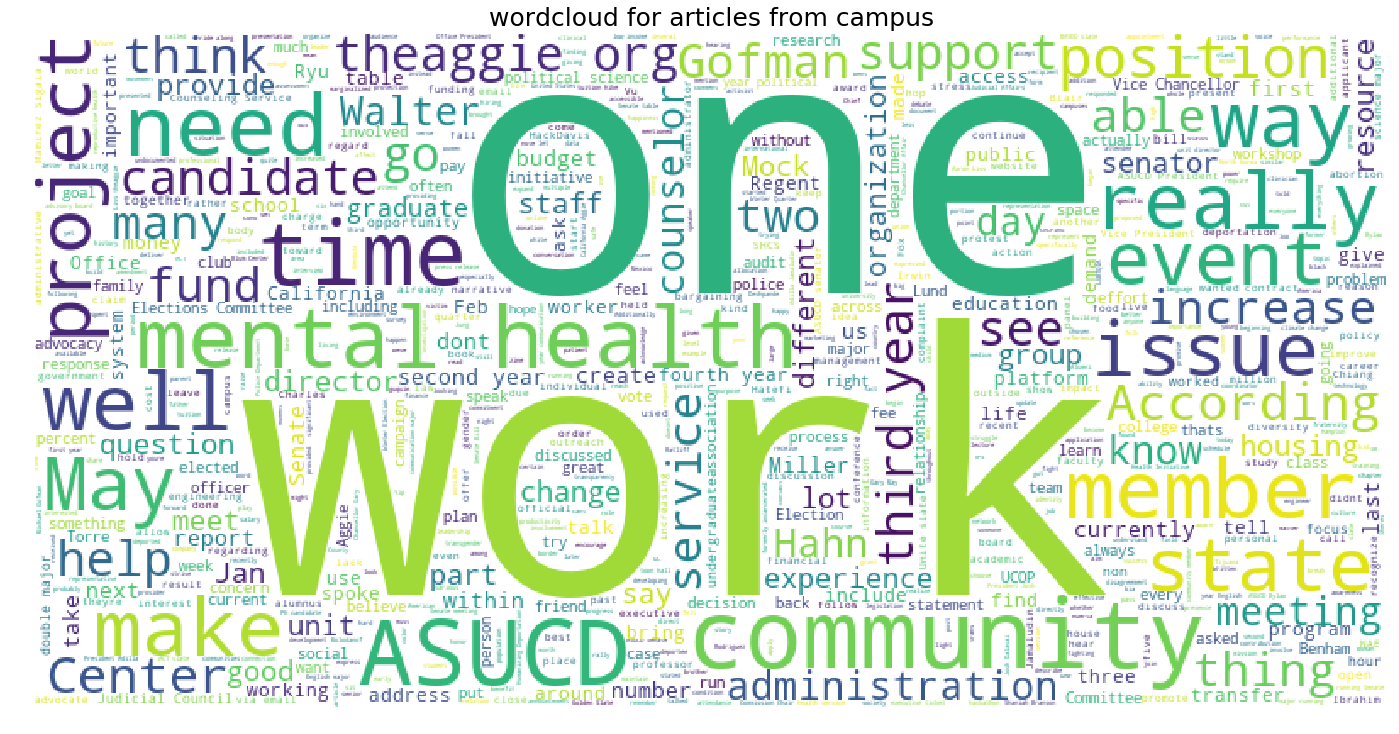

In [14]:
#wordcloud for campus: 
text=",".join(df_campus.text)
campus_text=blob_txt(text)
image=get_word_cloud("".join(campus_text))
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.axis("off")
plt.title("wordcloud for articles from campus",fontsize=25)
plt.tight_layout(pad=0)
plt.show()

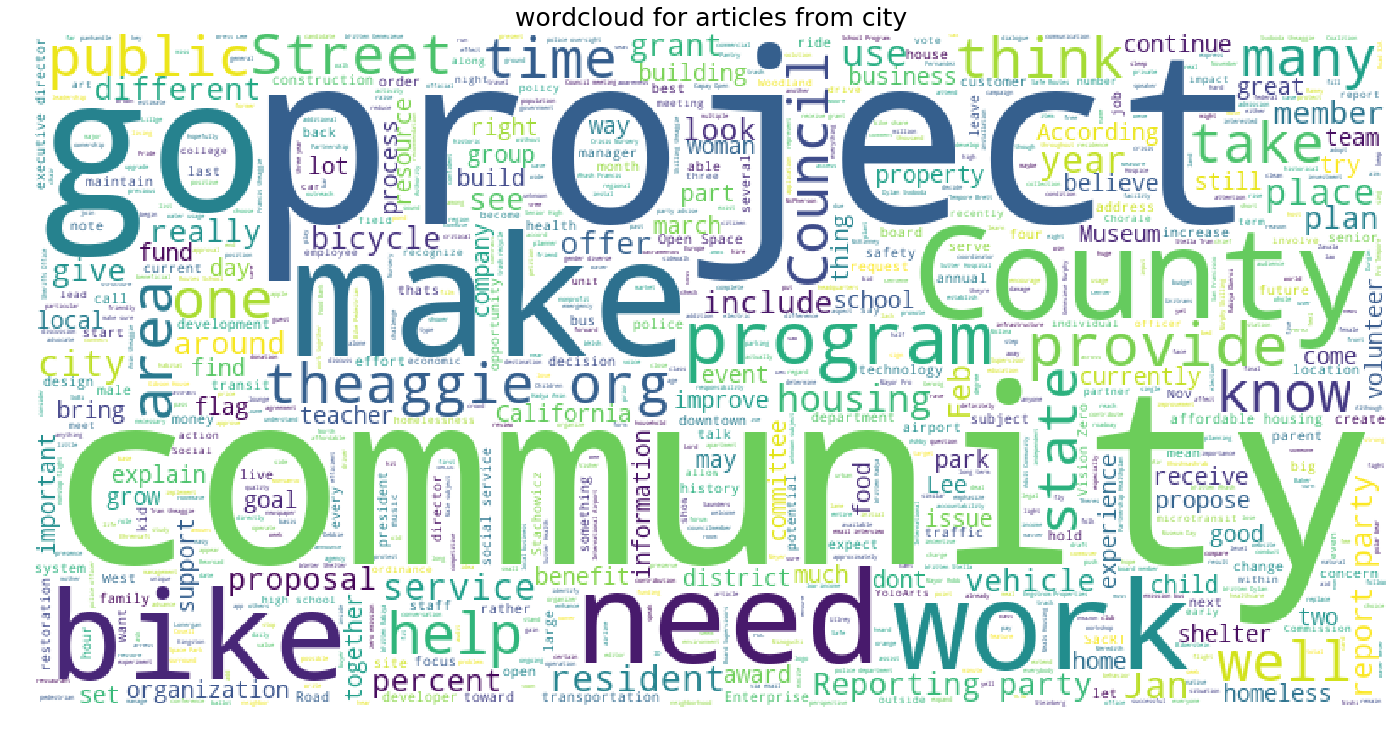

In [15]:
#wordcloud for city:
text=",".join(df_city.text)
city_text=blob_txt(text)
image=get_word_cloud("".join(city_text))
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.axis("off")
plt.title("wordcloud for articles from city",fontsize=25)
plt.tight_layout(pad=0)
plt.show()

From above, we can see that campus topic does have differences from city topic. On campus wordcloud, we can see one, work, mental health. While, on city wordcloud, we can see project, county and comunity. 

In [16]:
#1.4.2 
df_joined=df_joined.drop_duplicates()
temp=[blob_txt(item) for item in df_joined.text]
temp2=[' '.join(item.words) for item in temp]

a. below is show top 1 pair: 

In [19]:
tf_idf = TfidfVectorizer().fit_transform(temp2)
similarity=(tf_idf * tf_idf.T).A
similarity=np.tril(similarity)
np.fill_diagonal(similarity,0)
similarity[similarity>=1]=0 
indextuple=np.unravel_index(similarity.argmax(), similarity.shape)
print df_joined.iloc[indextuple[0],2]
print df_joined.iloc[indextuple[1],2]

Adam Hatefi and Shreya Deshpande disqualified after missing mandatory Candidate Workshop
Executive ticket candidates claim biases against non-ASUCD affiliated individuals


Top one similar articles are: 

Adam Hatefi and Shreya Deshpande disqualified after missing mandatory Candidate Workshop

Executive ticket candidates claim biases against non-ASUCD affiliated individuals

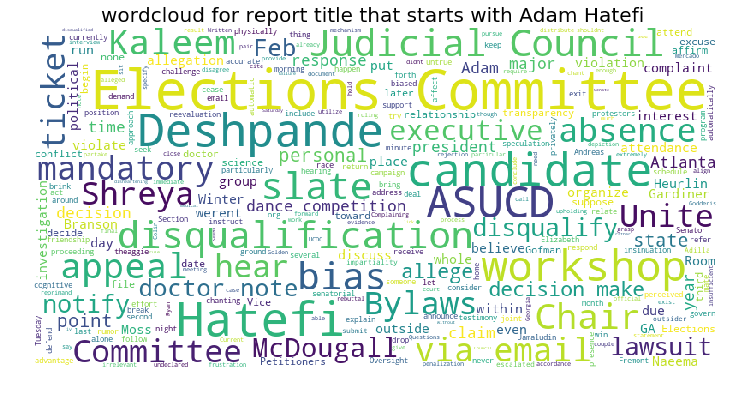

In [20]:
doc1=df_joined.iloc[indextuple[0],:]
doc1=blob_txt(doc1.text)
image=get_word_cloud("".join(doc1))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("wordcloud for report title that starts with Adam Hatefi ",fontsize=20)
plt.show()

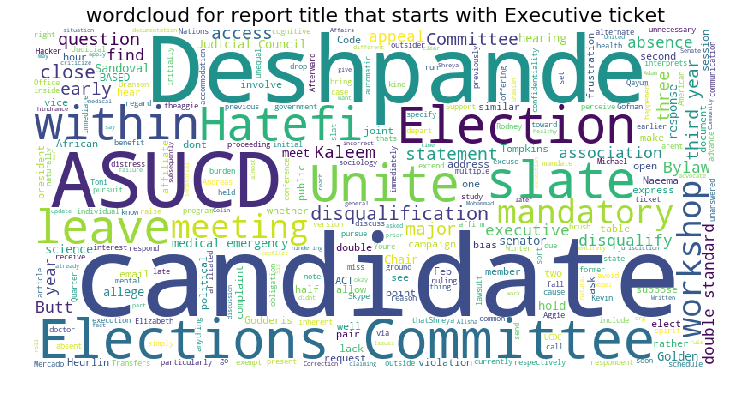

In [21]:
doc2=df_joined.iloc[indextuple[1],:]
doc2=blob_txt(doc2.text)
image=get_word_cloud("".join(doc2))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("wordcloud for report title that starts with Executive ticket",fontsize=20)
plt.show()

From above wordcloud, words that the pair shared are: ASUCD, deshpande, candidate. 

b. Below is to show top second pair: 
They are: 

Internal audit reveals steep decline in counselors, $250,000 worth of questionably allocated funds

Mental Health Town Hall erupts in protest

In [22]:
similarity[indextuple]=0
indextuple=np.unravel_index(similarity.argmax(), similarity.shape)
print df_joined.iloc[indextuple[0],2]
print df_joined.iloc[indextuple[1],2]

Internal audit reveals steep decline in counselors, $250,000 worth of questionably allocated funds
Mental Health Town Hall erupts in protest


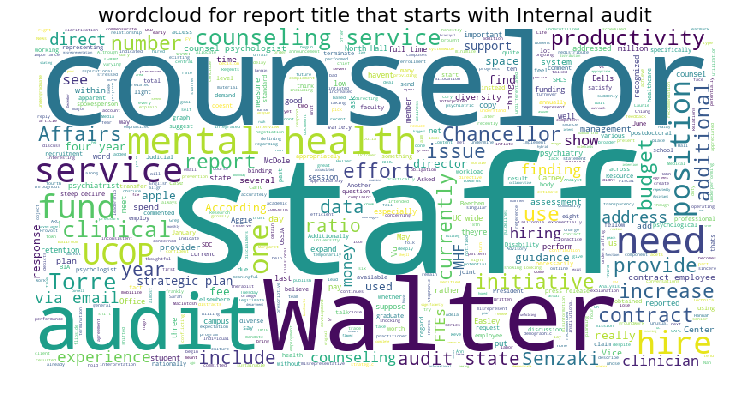

In [23]:
doc1=df_joined.iloc[indextuple[0],:]
doc1=blob_txt(doc1.text)
image=get_word_cloud("".join(doc1))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("wordcloud for report title that starts with Internal audit",fontsize=20)
plt.show()

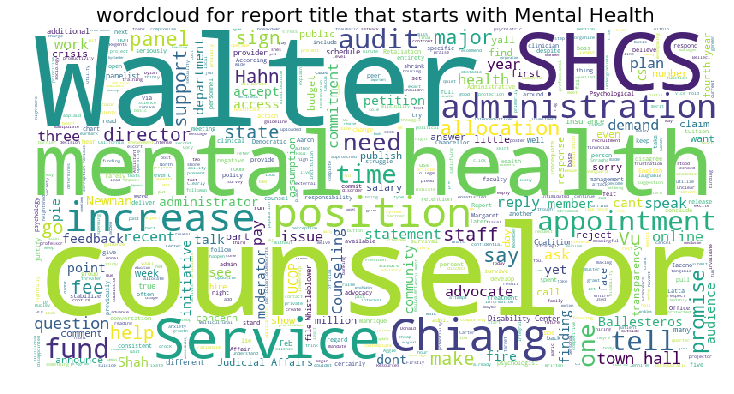

In [24]:
doc2=df_joined.iloc[indextuple[1],:]
doc2=blob_txt(doc2.text)
image=get_word_cloud("".join(doc2))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("wordcloud for report title that starts with Mental Health",fontsize=20)
plt.show()

Above word clouds shows similar words in: Walter, mental health and counselor

c. Below is to show top third pair: 
They are: 

Interfaith Rotating Winter Shelter to be held in Davis

New affordable housing and emergency service center proposed

word clouds shows similar words in: housing, shelter and community. 

In [25]:
similarity[indextuple]=0
indextuple=np.unravel_index(similarity.argmax(), similarity.shape)
print df_joined.iloc[indextuple[0],2]
print df_joined.iloc[indextuple[1],2]

Interfaith Rotating Winter Shelter to be held in Davis
New affordable housing and emergency service center proposed


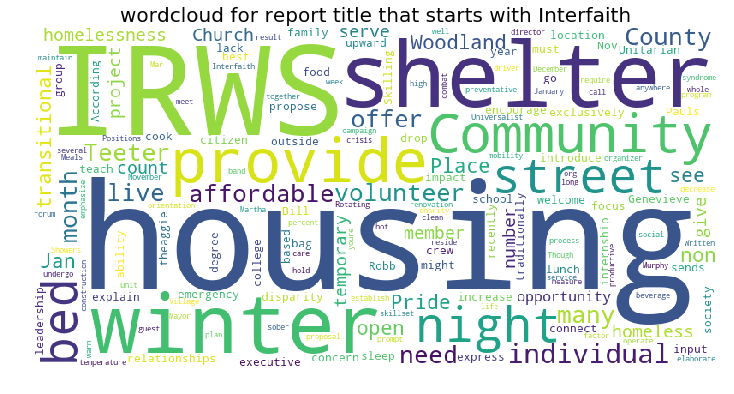

In [26]:
doc1=df_joined.iloc[indextuple[0],:]
doc1=blob_txt(doc1.text)
image=get_word_cloud("".join(doc1))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("wordcloud for report title that starts with Interfaith",fontsize=20)
plt.show()

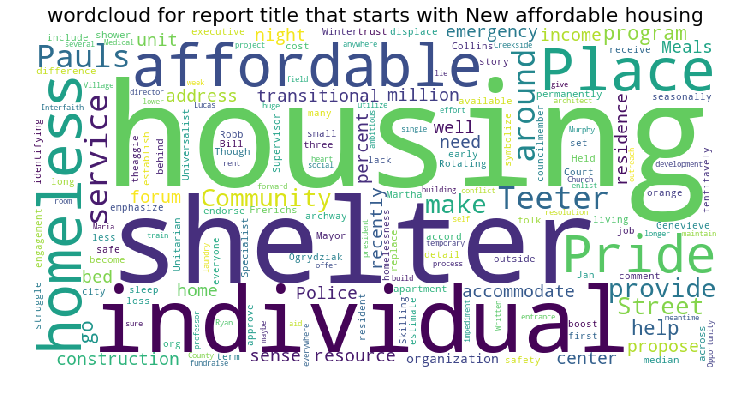

In [27]:
doc2=df_joined.iloc[indextuple[1],:]
doc2=blob_txt(doc2.text)
image=get_word_cloud("".join(doc2))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("wordcloud for report title that starts with New affordable housing",fontsize=20)
plt.show()

1.4.3.
It is relatively representative of the Aggie becasue I saw some words that indicate Aggie. But, the corpus is somewhat biased because it is strongly affected by the recent events. The corpus can infer about recent big events happped. But, at the other hand, some similar topics or follow up topics often come up as top of articles that are related. In this case, it does not really provide a good intuition on the major events because if one topic is spreaded to several articles, we may see only this event in the wordcloud and missing several other topics. 